# Sampling

In [1]:
import torch
from tqdm import tqdm
from checkpoint_entries import checkpoint_entries


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    try:
        if torch.backends.mps.is_available():
            return "mps"
    except AttributeError:
        pass
    return "cpu"


device = get_device()
betas = torch.linspace(1e-4, 0.02, 1000).to(device)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)
alphas_bar_previous = torch.cat([torch.tensor([1.0], device=device), alphas_bar[:-1]])
betas_tilde = betas * (1 - alphas_bar_previous) / (1 - alphas_bar)

checkpoint_entry_name = "attention_frozen"
model = checkpoint_entries[checkpoint_entry_name].get_model()
model = model.eval()
model = model.to(device)

In [2]:
from models.early_exit import OldEarlyExitUViT


bs = 8


def sample(threshold):
    torch.manual_seed(0)

    x = torch.randn(bs, 3, 32, 32).to(device)
    error_prediction_by_timestep = torch.zeros(1000, 13)
    indices_by_timestep = torch.zeros(1000, bs)
    for t in tqdm(range(999, -1, -1)):
        with torch.no_grad():
            time_tensor = t * torch.ones(bs, device=device)
            if isinstance(model, OldEarlyExitUViT):
                time_tensor /= 1000
            epsilon, classifier_outputs, outputs = model(x, time_tensor)

        outputs = torch.stack(outputs + [epsilon])
        classifier_outputs = torch.stack(
            classifier_outputs + [torch.zeros_like(classifier_outputs[0])]
        )

        # Simulate early exit with a global threshold
        indices = torch.argmax((classifier_outputs <= threshold).int(), dim=0)
        epsilon = outputs[indices, torch.arange(bs)]

        # Log for visualization
        error_prediction_by_timestep[t] = classifier_outputs.mean(axis=1)[:13]
        indices_by_timestep[t, :] = indices

        alpha_t = alphas[t]
        alpha_bar_t = alphas_bar[t]
        sigma_t = torch.sqrt(betas_tilde[t])

        z = torch.randn_like(x) if t > 0 else 0
        x = (
            torch.sqrt(1 / alpha_t)
            * (x - (1 - alpha_t) / (torch.sqrt(1 - alpha_bar_t)) * epsilon)
        ) + sigma_t * z

    return {
        "samples": x,
        "error_prediction_by_timestep": error_prediction_by_timestep,
        "indices_by_timestep": indices_by_timestep,
    }

In [3]:
results_by_threshold = {
    threshold: sample(threshold) for threshold in (0, 0.025, 0.05, 0.075, 0.1)
}

100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]


# Ground truth

In [4]:
from datasets import get_cifar10_dataloader

dl = get_cifar10_dataloader(batch_size=bs, seed=0)
num_batches = 5
actual_error_per_timestep = torch.zeros(1000, 14, device=device)

for batch_id, batch in zip(range(num_batches), dl):
    # for image in batch[0]:
    #     plt.imshow(rearrange(image, "c h w -> h w c"))
    #     plt.show()

    images = batch[0].to(device)

    for t in tqdm(range(1000)):
        noise = torch.randn_like(images)
        noisy_images = (
            torch.sqrt(alphas_bar[t]) * images + torch.sqrt(1 - alphas_bar[t]) * noise
        )

        time_tensor = t * torch.ones(bs, device=device)

        with torch.inference_mode():
            final_prediction, _, early_exit_noise_predictions = model(
                noisy_images, time_tensor
            )

        predictions = torch.stack(early_exit_noise_predictions + [final_prediction])

        actual_error = torch.tanh(torch.abs(predictions - noise))
        actual_error = actual_error.mean(dim=(-1, -2, -3, -4))
        actual_error_per_timestep[t, :] += actual_error

actual_error_per_timestep /= num_batches

Files already downloaded and verified


100%|██████████| 1000/1000 [01:36<00:00, 10.33it/s]


torch.Size([1400, 1000])


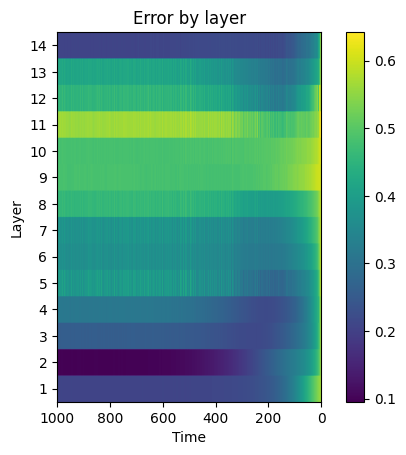

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Make the time be in the "x-axis"
matrix = actual_error_per_timestep.T.cpu()
# Make time go from T to 0 and
# make the first layer be down, and the last layer up
matrix = matrix.flip(dims=(0, 1))
# Since the dimensions are (14, 1000), we will repeat each row 100 times
matrix = matrix.repeat_interleave(repeats=100, dim=0)
print(matrix.shape)

plt.title("Error by layer")
plt.imshow(matrix)

plt.xlabel("Time")
plt.xticks(
    ticks=np.arange(0, 1001, 200),
    labels=np.arange(1000, -1, -200),
)

plt.ylabel("Layer")
plt.yticks(
    ticks=np.arange(100, 1401, 100) - 50,
    labels=np.arange(14, 0, -1),
)

plt.colorbar()
path = Path(f"images/{checkpoint_entry_name}/errors.svg")
path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(path)

# Classifier output plot

torch.Size([1300, 1000])


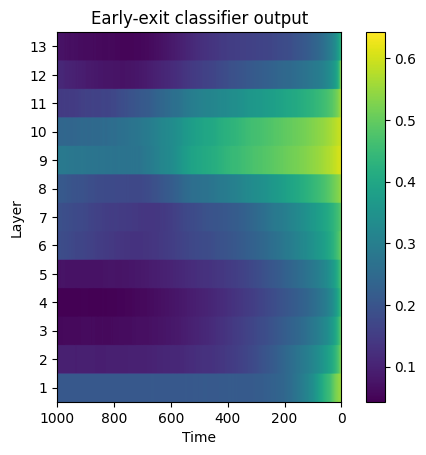

In [6]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Make the time be in the "x-axis"
matrix = results_by_threshold[0]["error_prediction_by_timestep"].T
# Make time go from T to 0 and
# make the first layer be down, and the last layer up
matrix = matrix.flip(dims=(0, 1))
# Since the dimensions are (13, 1000), we will repeat each row 100 times
matrix = matrix.repeat_interleave(repeats=100, dim=0)
print(matrix.shape)

plt.title("Early-exit classifier output")
plt.imshow(matrix)

plt.xlabel("Time")
plt.xticks(
    ticks=np.arange(0, 1001, 200),
    labels=np.arange(1000, -1, -200),
)

plt.ylabel("Layer")
plt.yticks(
    ticks=np.arange(100, 1301, 100) - 50,
    labels=np.arange(13, 0, -1),
)

plt.colorbar()
path = Path(f"images/{checkpoint_entry_name}/classifier_output.svg")
path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(path)

# Early-exit layer plot

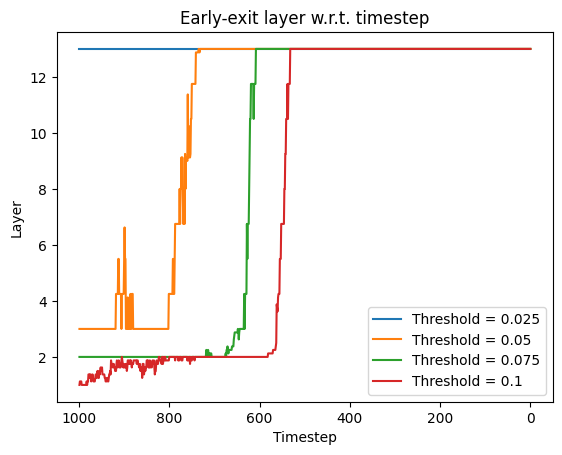

In [7]:
plt.title("Early-exit layer w.r.t. timestep")
time = np.arange(1000, 0, -1)


for threshold, results in results_by_threshold.items():
    if threshold == 0:
        continue
    indices_by_timestep = results["indices_by_timestep"]
    mean = indices_by_timestep.mean(axis=1)
    std = indices_by_timestep.std(axis=1)

    plt.plot(time, mean, label=f"Threshold = {threshold}")
    # plt.fill_between(time, mean - std, mean + std, alpha=0.1)

plt.legend()

plt.xlabel("Timestep")
plt.xticks(
    ticks=np.arange(0, 1001, 200),
    labels=np.arange(1000, -1, -200),
)

plt.ylabel("Layer")
path = Path(f"images/{checkpoint_entry_name}/exit_layer.svg")
path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(path)

# Samples plot

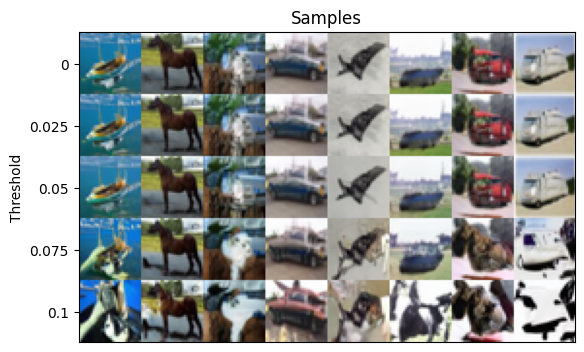

In [8]:
from einops import rearrange

num_thresholds = len(results_by_threshold)

final_image = []
for threshold, results in results_by_threshold.items():
    samples = results["samples"]
    samples = samples.cpu().numpy()
    samples = (samples + 1) / 2
    # Stack samples "horizontally"
    samples = rearrange(samples, "b c h w -> h (b w) c")
    final_image.append(samples)

# Stack vertically
final_image = np.concatenate(final_image)
final_image = np.clip(final_image, 0, 1)

plt.title("Samples")
plt.imshow(final_image)

plt.xticks([], [])

plt.yticks(np.arange(0, 32 * num_thresholds, 32) + 16, results_by_threshold.keys())
plt.ylabel("Threshold")
path = Path(f"images/{checkpoint_entry_name}/samples.svg")
path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(path)